In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys

%matplotlib inline

# !jupyter nbconvert --to script rec.ipynb

# Init data sizes and parametes of the PXM of ID16A

In [2]:
# cp.cuda.Device(int(sys.argv[1])).use()
# ntheta = int(sys.argv[2])#750  # number of angles (rotations)
# ptheta = int(sys.argv[3])  # holography chunk size for GPU processing
# binning = int(sys.argv[4])
# niter = int(sys.argv[5])
# iter_step = int(sys.argv[6])
# ndist = int(sys.argv[7])
# st =  int(sys.argv[8])
# same_probe =  sys.argv[9]=='True'
# flg_show = False

cp.cuda.Device(1).use()
ntheta = 180  # number of angles (rotations)
ptheta = 180  # holography chunk size for GPU processing
binning = 0
niter = 33
iter_step = 8
ndist = 1
st = 0
same_probe = True
flg_show = True



cropx_left = 0
cropx_right = 0
cropy_up = 0
cropy_down = 0

# cropx_left = 256
# cropx_right = 256
# cropy_up = 256
# cropy_down = 256

n = (256-cropx_left-cropx_right)//2**binning

ne = 512//2**binning
energy = 33.35 #[keV] xray energy
focusToDetectorDistance = 1.28 # [m]
sx0 = 3.7e-4
# z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = 10e-9*2**binning*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2


## Read data

In [3]:
data00 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref00 = np.zeros([ndist,n,n],dtype='float32')

for k in range(ndist):
    data00[k] = dxchange.read_tiff(f'data/modeling/data_3d_ald_syn_{n}_{k}.tiff')[:ntheta]
    ref00[k] = dxchange.read_tiff(f'data/modeling/ref_3d_ald_syn_{n}_{k}.tiff')
shifts = np.load('shifts.npy')[:ndist,:ntheta]/norm_magnifications[:,np.newaxis,np.newaxis]

# Dark-flat field correction

In [4]:

data0 = data00.copy()
ref0 = ref00.copy()
rdata=data0/(ref0[:,np.newaxis]+1e-9)
for k in range(ndist):
    dxchange.write_tiff(rdata[k],f'/data/viktor/tmp/tn{k}.tiff',overwrite=True)


In [5]:
print(ref0.shape)
if flg_show:

    for k in range(ndist-1):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(ref00[k],cmap='gray')
        axs[0].set_title('ref[0]')
        fig.colorbar(im)
        im=axs[1].imshow(ref0[1]-ref0[k],cmap='gray')#,vmin=-500,vmax=500)
        axs[1].set_title('ref[0] -ref[k] ')
        fig.colorbar(im)

# use second ref
# ref0[:] = ref0[1:2]#np.mean(ref0,axis=0)[np.newaxis]
# rdata=data0/(ref0[:,np.newaxis]+1e-9)


(1, 256, 256)


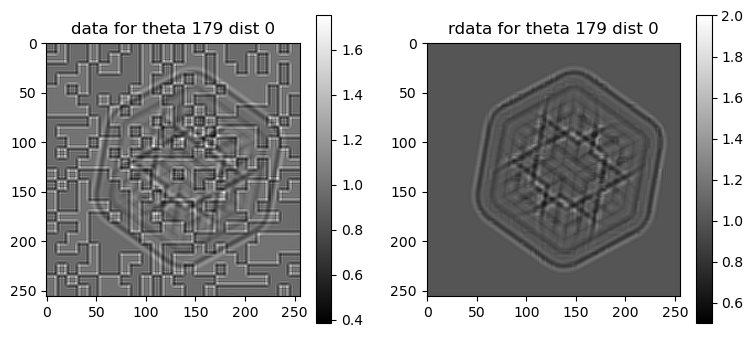

In [6]:
if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(data00[k,-1],cmap='gray')#,vmin = 0.5,vmax=2 )
        axs[0].set_title(f'data for theta {ntheta-1} dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata[k,-1],cmap='gray',vmin = 0.5,vmax=2)
        axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)

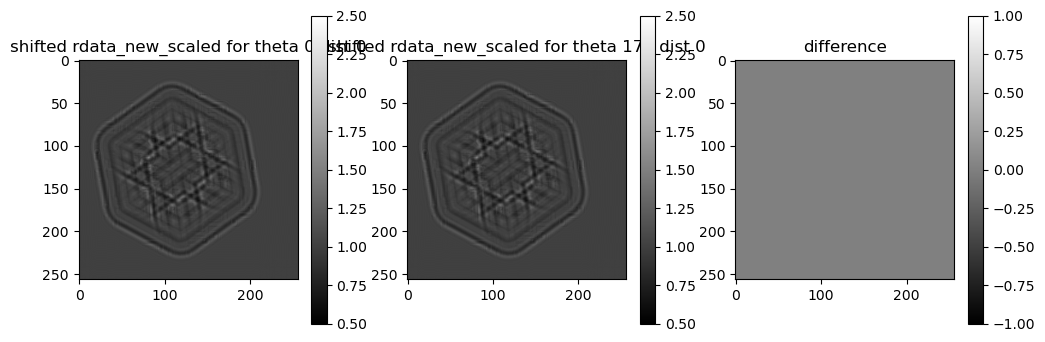

In [7]:
rdata_scaled = rdata.copy()
for j in range(ntheta):
    for k in range(ndist):    
        a = ndimage.zoom(rdata[k,j],1/norm_magnifications[k])
        rdata_scaled[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled[0,0],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled[k,0],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled[0,0]-rdata_scaled[k,0],cmap='gray',vmin =-1,vmax=1 )
        axs[2].set_title(f'difference')
        fig.colorbar(im)        

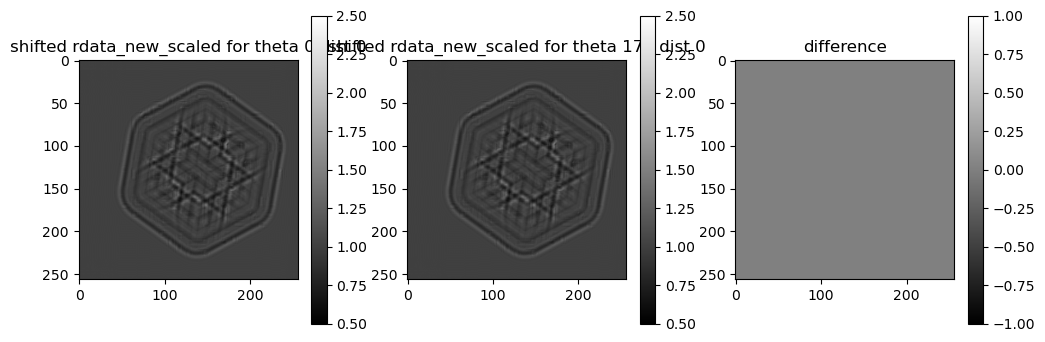

In [8]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
rdata_scaled_new = rdata.copy()
for j in range(ntheta):
    for k in range(ndist):    
        a = apply_shift(rdata[k,j:j+1],-shifts[k,j:j+1]*norm_magnifications[k,np.newaxis,np.newaxis])[0]# note first shift then magnification
        a = ndimage.zoom(a,1/norm_magnifications[k])
        rdata_scaled_new[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]  

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled_new[0,-1],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled_new[k,-1],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled_new[0,-1]-rdata_scaled_new[k,-1],cmap='gray',vmin =-1,vmax=1 )
        axs[2].set_title(f'difference')
        fig.colorbar(im)          
    

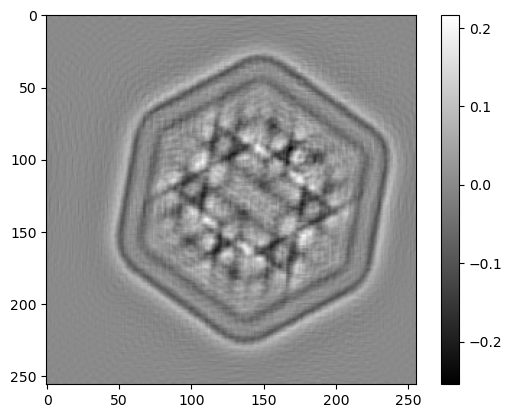

In [9]:
def CTFPurePhase(rads, wlen, dists, fx, fy, alpha):
   """
   weak phase approximation from Cloetens et al. 2002




   Parameters
   ----------
   rad : 2D-array
       projection.
   wlen : float
       X-ray wavelentgth assumes monochromatic source.
   dist : float
       Object to detector distance (propagation distance) in mm.
   fx, fy : ndarray
       Fourier conjugate / spatial frequency coordinates of x and y.
   alpha : float
       regularization factor.
       
   Return
   ------
   phase retrieved projection in real space
   """    
   numerator = 0
   denominator = 0    
   for j in range(0, len(dists)):    
       rad_freq = np.fft.fft2(rads[j])
       taylorExp = np.sin(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
       numerator = numerator + taylorExp * (rad_freq)
       denominator = denominator + 2*taylorExp**2 
   numerator = numerator / len(dists)
   denominator = (denominator / len(dists)) + alpha
   phase = np.real(  np.fft.ifft2(numerator / denominator) )
   phase = 0.5 * phase
   return phase

def multiPaganin(rads, wlen, dists, delta_beta, fx, fy, alpha):
    """
    Phase retrieval method based on Contrast Transfer Function. This 
    method relies on linearization of the direct problem, based  on  the
    first  order  Taylor expansion of the transmittance function.
    Found in Yu et al. 2018 and adapted from Cloetens et al. 1999


    Parameters
    ----------
    rad : 2D-array
        projection.
    wlen : float
        X-ray wavelentgth assumes monochromatic source.
    dist : float
        Object to detector distance (propagation distance) in mm.
    delta : float    
        refractive index decrement
    beta : float    
        absorption index
    fx, fy : ndarray
        Fourier conjugate / spatial frequency coordinates of x and y.
    alpha : float
        regularization factor.
        
    Return
    ------

    phase retrieved projection in real space
    """    
    numerator = 0
    denominator = 0    
    for j in range(0, len(dists)):    
        rad_freq = np.fft.fft2(rads[j])    
        taylorExp = 1 + wlen * dists[j] * np.pi * (delta_beta) * (fx**2+fy**2)
        numerator = numerator + taylorExp * (rad_freq)
        denominator = denominator + taylorExp**2 

    numerator = numerator / len(dists)
    denominator = (denominator / len(dists)) + alpha

    phase = np.log(np.real(  np.fft.ifft2(numerator / denominator) ))    
    phase = (delta_beta) * 0.5 * phase

    
    return phase

distances_rec = (distances/norm_magnifications**2)[:ndist]

fx = np.fft.fftfreq(n,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)

wlen = 1.24e-9/energy
recCTFPurePhase = np.zeros([ntheta,n,n],dtype='complex64')
recMultiPaganin = np.zeros([ntheta,n,n],dtype='complex64')
for k in range(ntheta):
    rads = rdata_scaled_new[:ndist,k]
    # recCTFPurePhase[k] = np.exp(1j*CTFPurePhase(rads, wlen, distances_rec, fx, fy, 1e-3))
    recCTFPurePhase[k] = np.exp(1j*CTFPurePhase(rads, wlen, distances_rec, fx, fy, 1e-2))
    recMultiPaganin[k] = np.exp(1j*multiPaganin(rads, wlen, distances_rec, 100, fx, fy, 1e-12))
if flg_show:
    plt.imshow(np.angle(recCTFPurePhase[-1]),cmap='gray')
    plt.colorbar()
dxchange.write_tiff(np.angle(recCTFPurePhase),f'/data/vnikitin/holo/3d_ald_syn/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/CTF.tiff',overwrite=True)
dxchange.write_tiff(np.angle(recMultiPaganin),f'/data/vnikitin/holo/3d_ald_syn/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/MultiPaganin.tiff',overwrite=True)



In [10]:
dxchange.write_tiff(np.angle(recMultiPaganin),f'/data/vnikitin/holo/3d_ald_syn/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/MultiPaganin.tiff',overwrite=True)

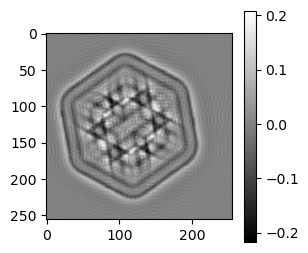

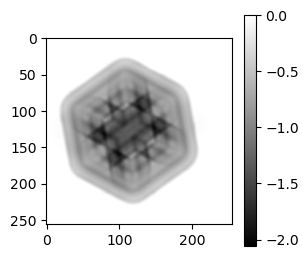

In [11]:
plt.figure(figsize=(3,3))
plt.imshow(np.angle(recCTFPurePhase[0]),cmap='gray')
plt.colorbar()
plt.savefig(f'figs/recCTFPurePhase.png',dpi=300,bbox_inches='tight')
plt.figure(figsize=(3,3))
plt.imshow(np.angle(recMultiPaganin[0]),cmap='gray',vmin=-2.0621095,vmax=0)
plt.colorbar()
plt.savefig(f'figs/recMultiPaganin.png',dpi=300,bbox_inches='tight')

## Create a solver class for holography

In [12]:
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications,distances2,same_probe=same_probe)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Adjoint test

In [13]:
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')
prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
shifts_ref = shifts[:]
print(arr1.shape,prb1.shape,shifts_ref.shape)
arr2 = pslv.fwd_holo_batch(arr1,prb1, shifts_ref)
arr3 = pslv.adj_holo_batch(arr2,prb1, shifts_ref)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, shifts_ref)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(180, 512, 512) (1, 256, 256) (1, 180, 2)
(48013984+0.054825656j)
(48013870-6.678205e-05j)
(48013892+0.035376135j)


In [14]:
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2 + \||\mathcal{G}_{d_0}q|-\sqrt{\text{I}_r}\|_2^2\to \text{min}_{\psi_i,q}$ 

In [15]:

from holotomo.utils import chunk
def adj_holo_batch_ext(pslv,fpsi, data, prb, shifts=None, code=None, shifts_code=None):
    """Batch of Holography transforms"""
    res = np.zeros([ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_gpu = cp.array(prb)
    shifts_gpu = None        
    shifts_code_gpu = None
    code_gpu = None

    if code is not None:
        code_gpu = cp.array(code)   
    for ids in chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        fpsi_gpu = cp.array(fpsi[:, ids])
        data_gpu = cp.array(data[:, ids])
            
        if shifts is not None:
            shifts_gpu = cp.array(shifts[:,ids])
        if shifts_code is not None:
            shifts_code_gpu = cp.array(shifts_code[:,ids])
        fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(cp.angle(fpsi_gpu)))        
        # Radon transform
        res_gpu = -pslv.adj_holo(fpsi_gpu, prb_gpu, shifts_gpu, code_gpu, shifts_code_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def adj_holo_prb_batch_ext(pslv, fpsi, data, psi, shifts=None, code=None, shifts_code=None):
        """Batch of Holography transforms"""
        res = np.zeros([len(pslv.distances), pslv.n, pslv.n], dtype='complex64')
        shifts_gpu = None        
        shifts_code_gpu = None
        code_gpu = None
        if code is not None:
            code_gpu = cp.array(code)   
        for ids in chunk(range(pslv.ntheta), pslv.ptheta):
            # copy data part to gpu
            fpsi_gpu = cp.array(fpsi[:, ids])
            psi_gpu = cp.array(psi[ids])
            data_gpu = cp.array(data[:, ids])
            
            if shifts is not None:
                shifts_gpu = cp.array(shifts[:,ids])
            if shifts_code is not None:
                shifts_code_gpu = cp.array(shifts_code[:,ids])
            # Radon transform
            fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(cp.angle(fpsi_gpu)))                
            # fprb-data*np.exp(1j*np.angle(fprb))
            res_gpu = -pslv.adj_holo_prb(fpsi_gpu, psi_gpu, shifts_gpu,code_gpu,shifts_code_gpu)
            # copy result to cpu
            res += res_gpu.get()
        return res

def cg_holo_batch2(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        f += np.linalg.norm(np.abs(fprb)-data_ref)**2        
        return f        
    
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    
    for i in range(piter):
        if upd_psi:
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts)          
            # d = -pslv.adj_holo_batch(fpsi-data*np.exp(1j*(np.angle(fpsi))), prb,shifts)/np.max(np.abs(prb))**2
            d = adj_holo_batch_ext(pslv,fpsi,data, prb,shifts)/np.max(np.abs(prb))**2
                       
            # line search
            fd = pslv.fwd_holo_batch(d, prb,shifts)                 
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil)
            
            # dprb = -pslv.adj_holo_prb_batch(fprb-data*np.exp(1j*np.angle(fprb)),psi,shifts)#/ndist**2
            # dprb -= pslv0.adj_holo_prb_batch(fprb0-data_ref*np.exp(1j*np.angle(fprb0)),psi_nil,shifts_nil)
            
            dprb = adj_holo_prb_batch_ext(pslv,fprb,data,psi,shifts)#/ndist**2            
            dprb += adj_holo_prb_batch_ext(pslv0,fprb0,data_ref,psi_nil,shifts_nil)
            dprb *= 1/((pslv.ntheta+1))
            

            # line search
            fdprb = pslv.fwd_holo_batch(psi, dprb,shifts)
            fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil)
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)
    
        
        if i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(np.angle(recCTFPurePhase[0]),cmap='gray')
                axs[0].set_title('reconstructed CTF phase')
                fig.colorbar(im)
                im=axs[1].imshow(np.angle(psi[0,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(np.angle(psi),f'/data/vnikitin/holo/3d_ald/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.angle(psi[0]),f'/data/vnikitin/holo/3d_ald/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)
            
    return psi,prb


In [16]:

def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    shifts = cp.array(shifts)
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    conv=np.zeros(piter)
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts)          
            # d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2
            grad = pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2
            
            #d = -grad
            # Dai-Yuan direction
            if i == 0:
                d = -grad
            else:
                d = -grad+cp.linalg.norm(grad)**2 / \
                    ((cp.sum(cp.conj(d)*(grad-grad0))))*d
            grad0 = grad
            fd = pslv.fwd_holo(d, prb,shifts)     
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
      
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil)
            gradprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts)
            gradprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil)
            gradprb*=1/(pslv.ntheta+1)
            
            #dprb = -gradprb
             # Dai-Yuan direction
            if i == 0:
                dprb = -gradprb
            else:
                dprb = -gradprb+cp.linalg.norm(gradprb)**2 / \
                    ((cp.sum(cp.conj(dprb)*(gradprb-gradprb0))))*dprb
            gradprb0 = gradprb
            # dprb -= pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil)

            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil)
            
            gammaprb = line_search(minf,gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')  
            conv[i]=err
            
        
        if i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(np.angle(recMultiPaganin[0]),cmap='gray')
                axs[0].set_title('reconstructed CTF phase')
                fig.colorbar(im)
                im=axs[1].imshow(cp.angle(psi[0,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]).get(),cmap='gray')
                # im=axs[1].imshow(cp.angle(psi[0,:,:]).get(),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/3d_ald_syn/r_{n}_{ntheta}_{ndist}_{st}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.abs(psi).get(),f'/data/vnikitin/holo/3d_ald_syn/rabs_{n}_{ntheta}_{ndist}_{st}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/3d_ald_syn/r_{n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.abs(prb[0]).get(),f'/data/vnikitin/holo/3d_ald_syn/pabs_{n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(prb[0]).get(),f'/data/vnikitin/holo/3d_ald_syn/pangle_{n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)            
            np.save(f'/data/vnikitin/holo/3d_ald_syn/conv_{n}_{ntheta}_{ndist}_{st}',conv)            
            
    return psi,prb,conv

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,upd_psi=True,upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                

    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu,conv = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb,conv


0) gammapsi=0.5 gammaprb=1, err=3.91473e-08


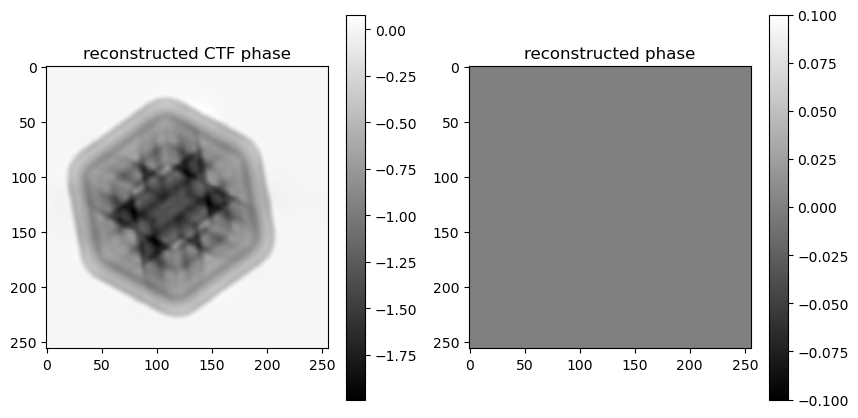

1) gammapsi=0.5 gammaprb=1, err=7.65925e-09
2) gammapsi=0.5 gammaprb=1, err=6.10643e-09
3) gammapsi=0.5 gammaprb=1, err=6.55711e-09
4) gammapsi=0.5 gammaprb=1, err=8.65763e-09
5) gammapsi=0.5 gammaprb=1, err=1.04494e-08
6) gammapsi=0.5 gammaprb=0.5, err=1.29736e-08
7) gammapsi=0.5 gammaprb=0.25, err=9.86915e-09
8) gammapsi=0.5 gammaprb=0.5, err=1.34254e-08
9) gammapsi=0.5 gammaprb=0.5, err=1.23134e-08
10) gammapsi=0.5 gammaprb=0.5, err=1.22070e-08
11) gammapsi=0.5 gammaprb=0.5, err=1.47862e-08
12) gammapsi=0.5 gammaprb=0.25, err=1.37253e-08
13) gammapsi=0.5 gammaprb=0.25, err=1.47316e-08
14) gammapsi=0.5 gammaprb=0.25, err=1.32188e-08
15) gammapsi=0.5 gammaprb=0.25, err=1.18616e-08
16) gammapsi=0.5 gammaprb=0.25, err=1.15980e-08
17) gammapsi=0.5 gammaprb=0.25, err=1.11781e-08
18) gammapsi=0.5 gammaprb=0.25, err=1.25726e-08
19) gammapsi=0.5 gammaprb=0.25, err=1.35036e-08
20) gammapsi=0.5 gammaprb=0.125, err=1.45242e-08
21) gammapsi=0.5 gammaprb=0.25, err=1.43492e-08
22) gammapsi=0.5 gam

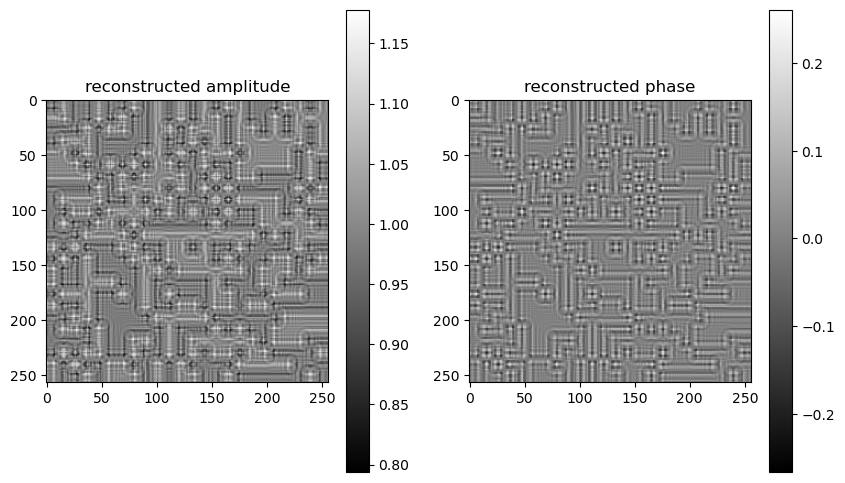

In [17]:

pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 
pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 


rec = np.ones([1,ne,ne],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = np.sqrt(ref0[:,np.newaxis])
shifts_ref = np.array(shifts)[:,:1]*0
_,rec_prb0,conv = cg_holo_batch(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 33, shifts_ref, False,True,1,33,0.5,1)
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
    axs[0].set_title('reconstructed amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)

In [18]:


# shifts_rec = np.array(shifts)
# rec = np.ones([ntheta,pslv.ne,pslv.ne],dtype='complex64')
# rec = np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')
# # use only the abs value of the probe as initial guess
# rec_prb[:] = rec_prb0

# data_ref = np.sqrt(ref0[:,np.newaxis])
# data_rec = np.sqrt(data0)

# rec,rec_prb,conv = cg_holo_batch(pslv, pslv0, data_rec, data_ref, rec, rec_prb, 20000, shifts_rec, True,True,1,1, 1,2)

In [21]:
rec = np.ones([ntheta,pslv.ne,pslv.ne],dtype='complex64')
rec = np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')

import scipy.ndimage as ndimage
prb_abs = dxchange.read_tiff(f'/data/vnikitin/modeling/prb_abs_3d_ald_syn_codes_256_180_33.35_1.0e-02_1.0e-06_False_True_4_2_1.00e-06.tiff')#[0:ndist]
prb_phase = dxchange.read_tiff(f'/data/vnikitin/modeling/prb_angle_3d_ald_syn_codes_256_180_33.35_1.0e-02_1.0e-06_False_True_4_2_1.00e-06.tiff')#[0:ndist]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
print(np.linalg.norm(prb))#.shape)

# prb_abs = dxchange.read_tiff(f'../data/prb_id16a/prb_abs_{2048}.tiff')[0:ndist]
# prb_phase = dxchange.read_tiff(f'../data/prb_id16a/prb_phase_{2048}.tiff')[0:ndist]
# prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
# prb[:] = prb[0]



# for k in range(2):
#     prb = prb[:,::2]+prb[:,1::2]
#     prb = prb[:,:,::2]+prb[:,:,1::2]/4
# # prb = ndimage.rotate(prb,20,axes=(1,2),reshape=False)

# rec_prb0 = prb[:,128:-128,128:-128]

data0 = data.copy()
data_ref0 = data_ref.copy()
rec0 = rec.copy()
prb0 = rec_prb0.copy()
n0 = n
ne0 = ne
voxelsize0 = voxelsize
shifts_rec0 = np.array(shifts)


506.90665


n=256,ne=512,voxelsize=8e-08
0) gammapsi=1 gammaprb=1.0, err=1.76444e+02


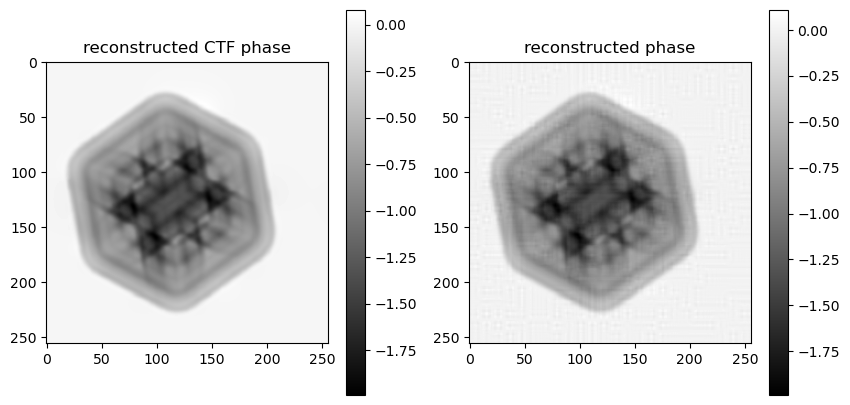

32) gammapsi=0.125 gammaprb=6.103515625e-05, err=5.55777e+00


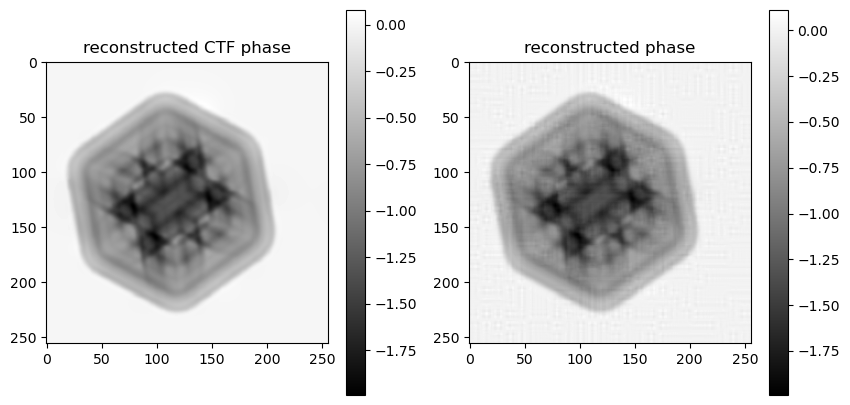

64) gammapsi=0.5 gammaprb=1.0, err=4.64587e+00


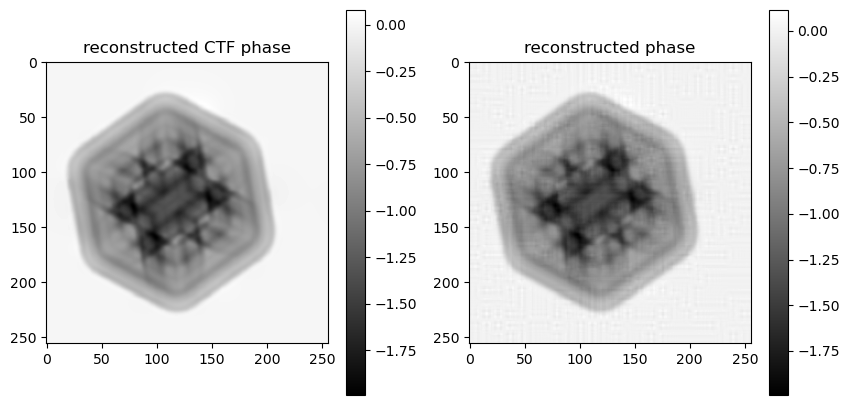

96) gammapsi=1 gammaprb=0.00390625, err=4.09460e+00


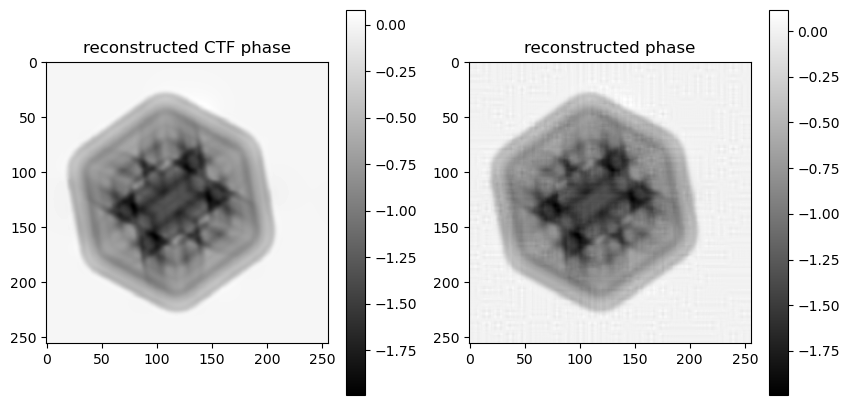

128) gammapsi=0.0625 gammaprb=2, err=3.42856e+00


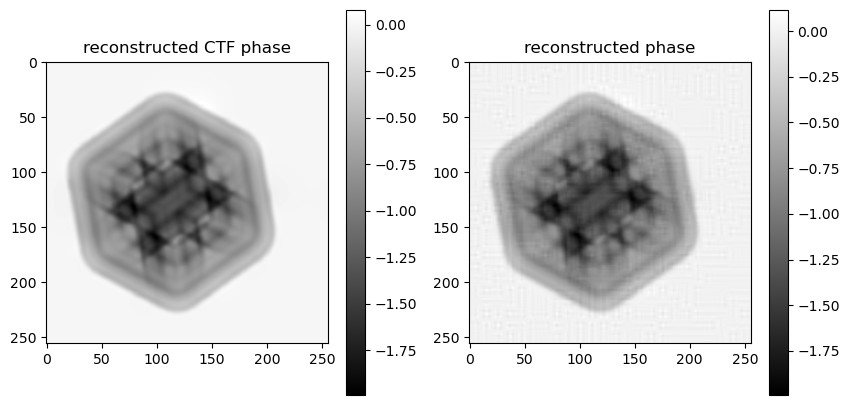

160) gammapsi=1 gammaprb=0.25, err=3.25218e+00


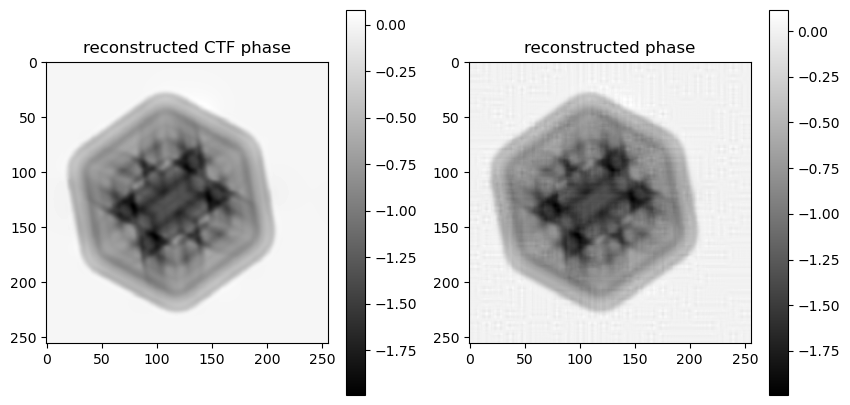

192) gammapsi=1 gammaprb=1.0, err=3.07615e+00


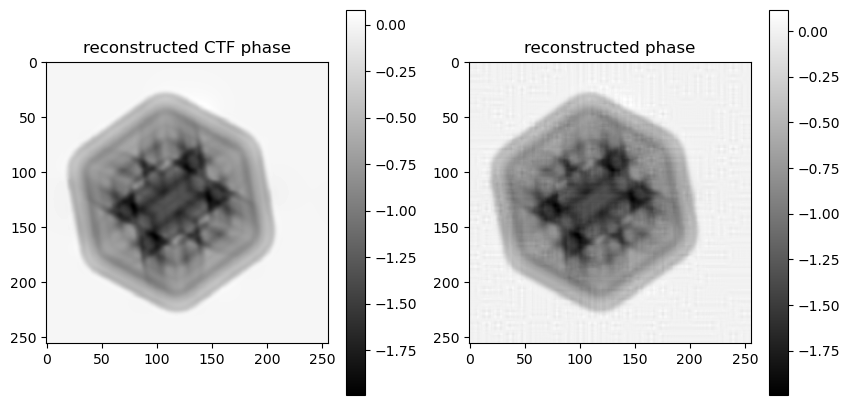

224) gammapsi=1 gammaprb=0.5, err=2.81752e+00


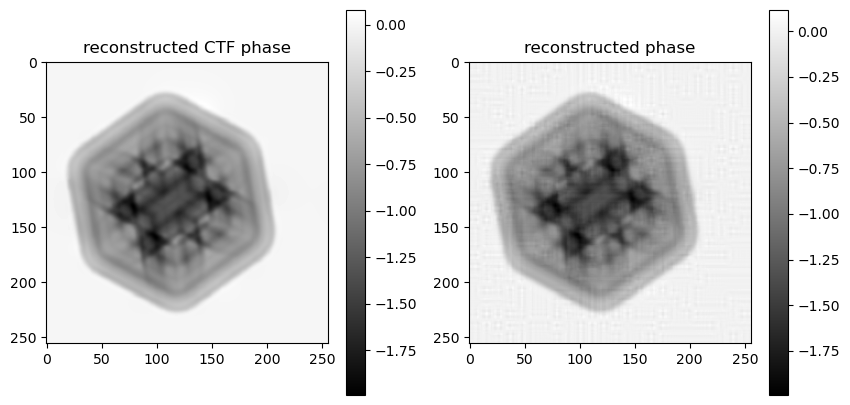

256) gammapsi=1 gammaprb=3.0517578125e-05, err=2.51877e+00


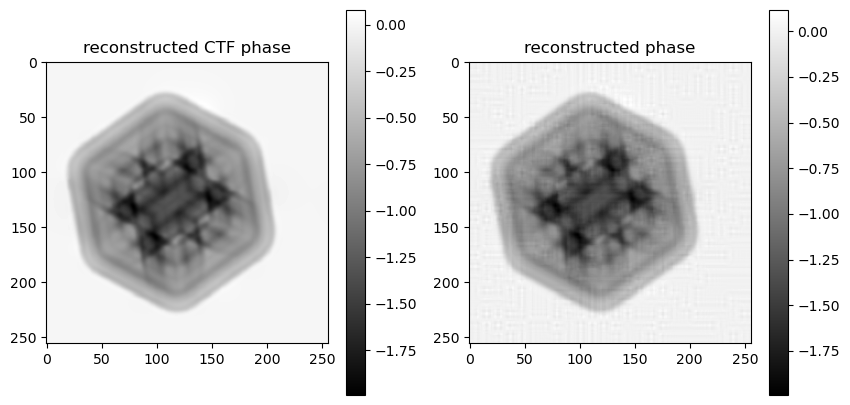

288) gammapsi=1 gammaprb=1.0, err=2.41293e+00


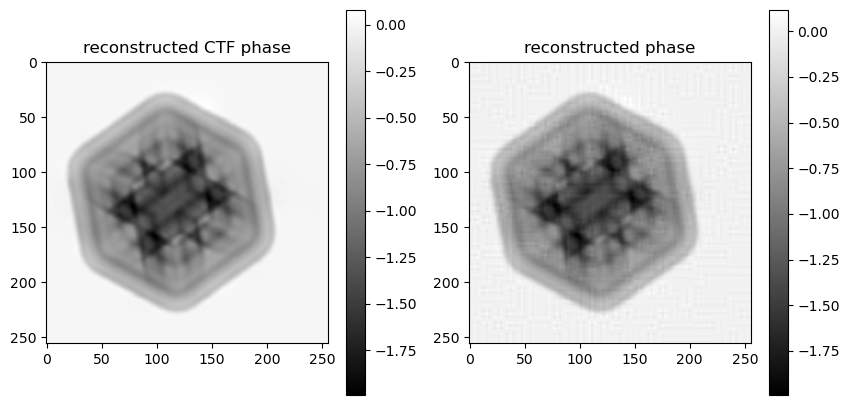

320) gammapsi=0.25 gammaprb=0.5, err=1.97413e+00


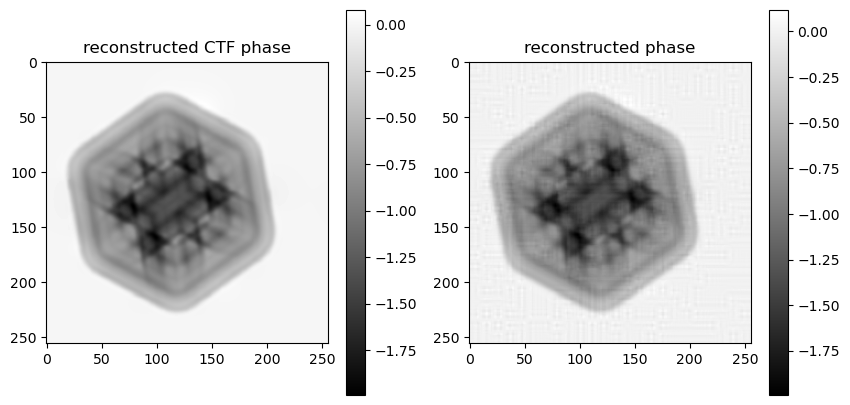

352) gammapsi=0.25 gammaprb=1.0, err=1.82795e+00


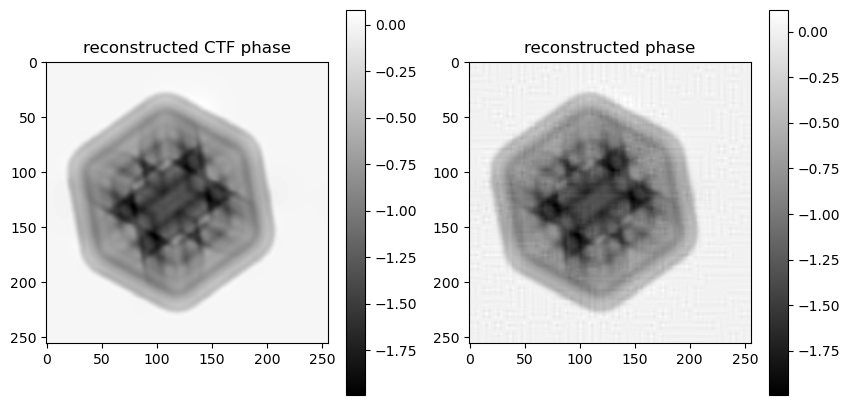

384) gammapsi=1 gammaprb=0.015625, err=1.69024e+00


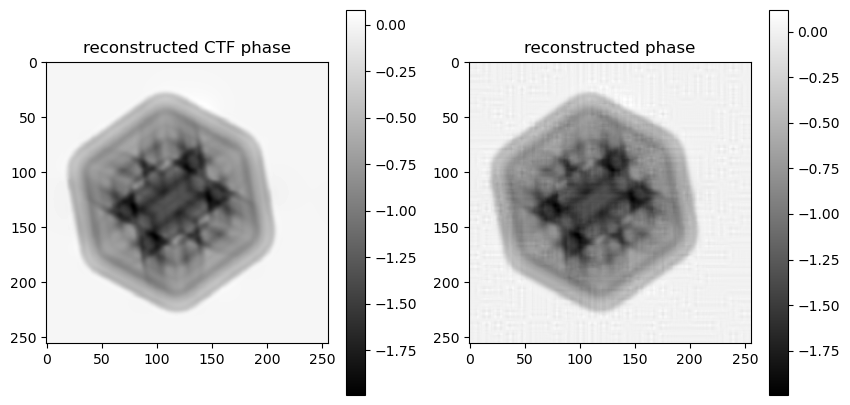

416) gammapsi=1 gammaprb=0.0009765625, err=1.52086e+00


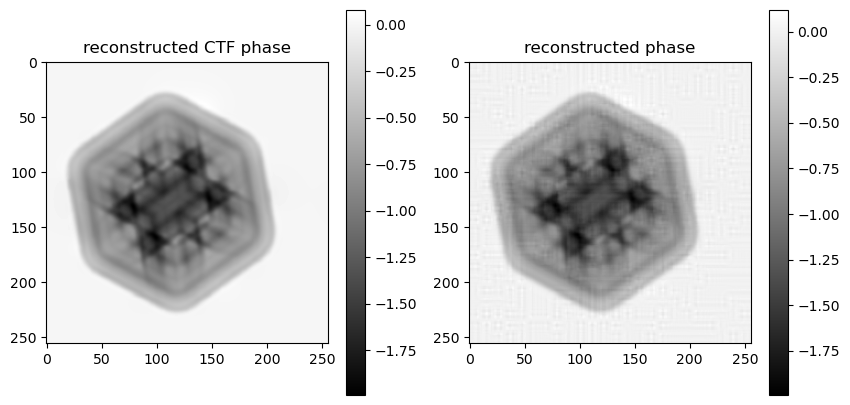

448) gammapsi=1 gammaprb=1.0, err=1.37225e+00


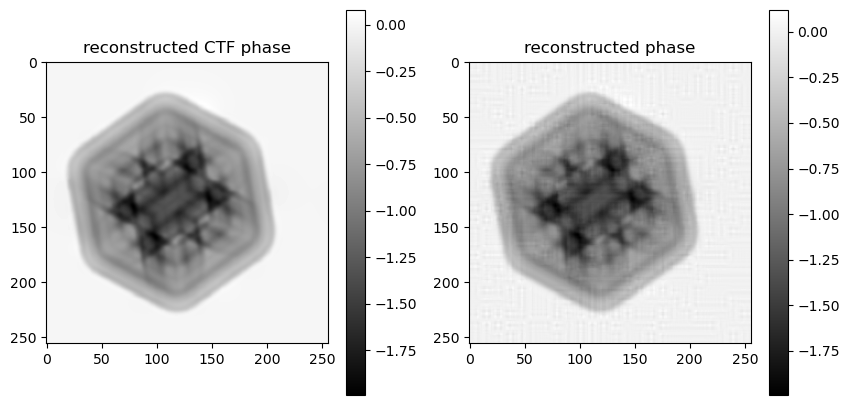

480) gammapsi=0.03125 gammaprb=1.0, err=1.27137e+00


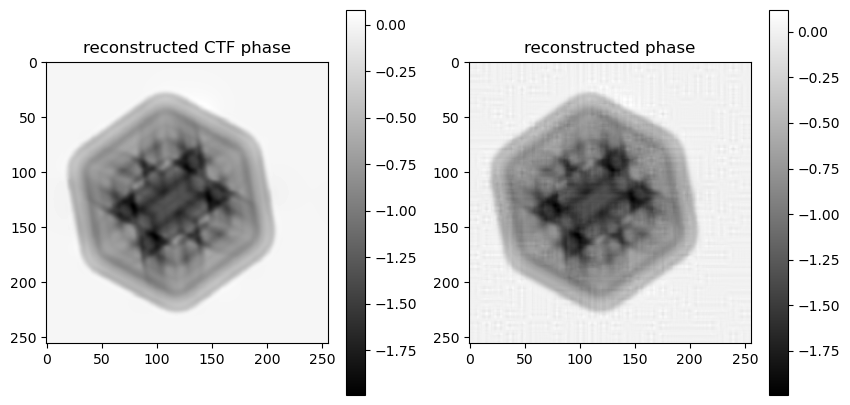

512) gammapsi=1 gammaprb=0.25, err=1.11473e+00


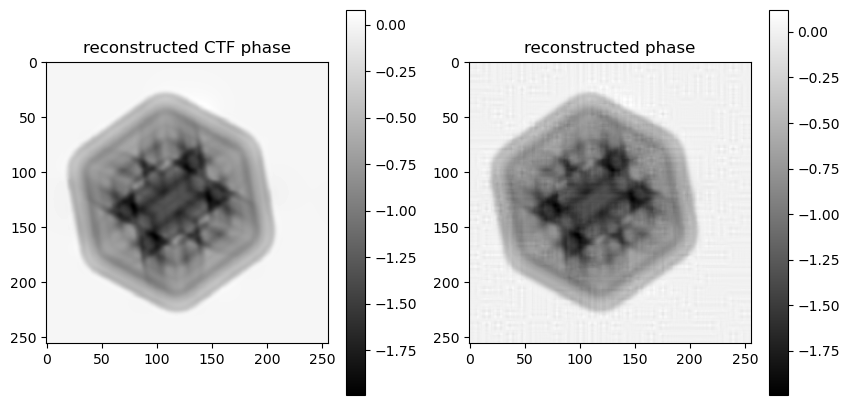

544) gammapsi=0.25 gammaprb=1.9073486328125e-06, err=9.84171e-01


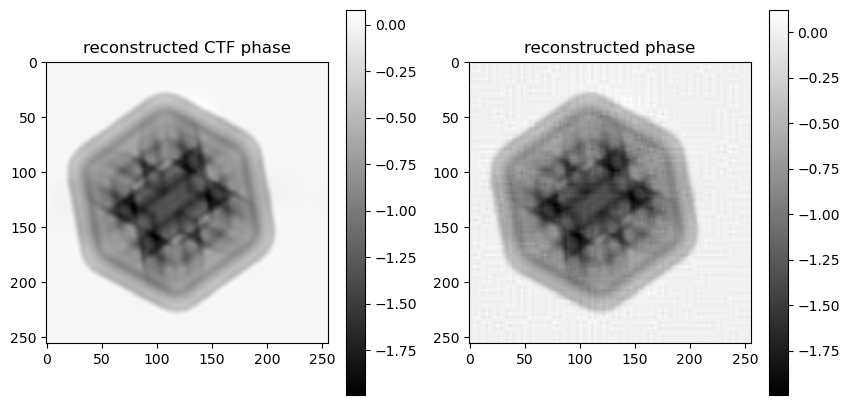

576) gammapsi=1 gammaprb=7.62939453125e-06, err=8.81918e-01


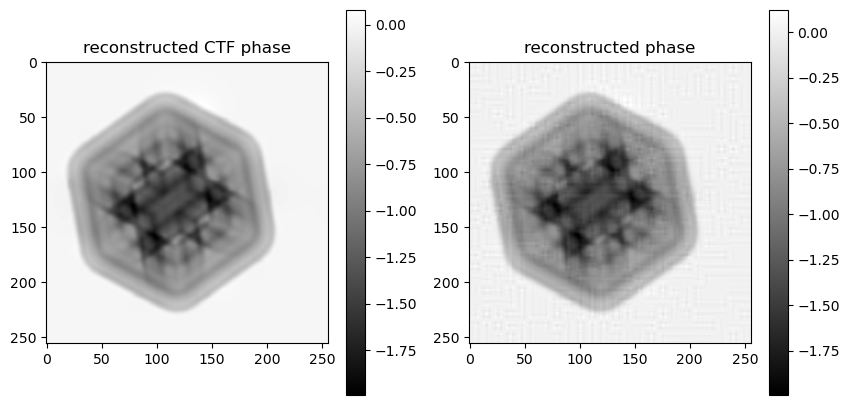

608) gammapsi=1 gammaprb=0.5, err=7.89599e-01


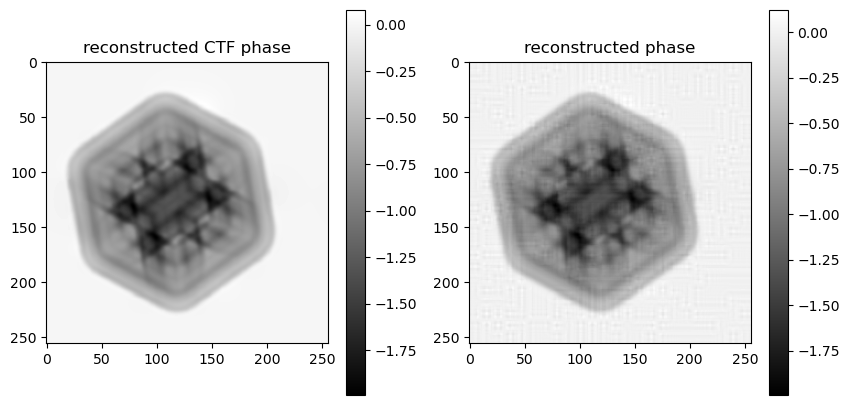

640) gammapsi=0.015625 gammaprb=2, err=7.34647e-01


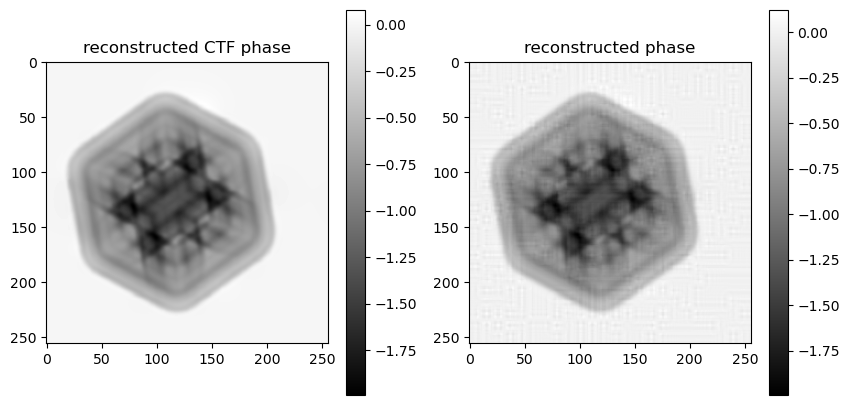

672) gammapsi=1 gammaprb=6.103515625e-05, err=6.45748e-01


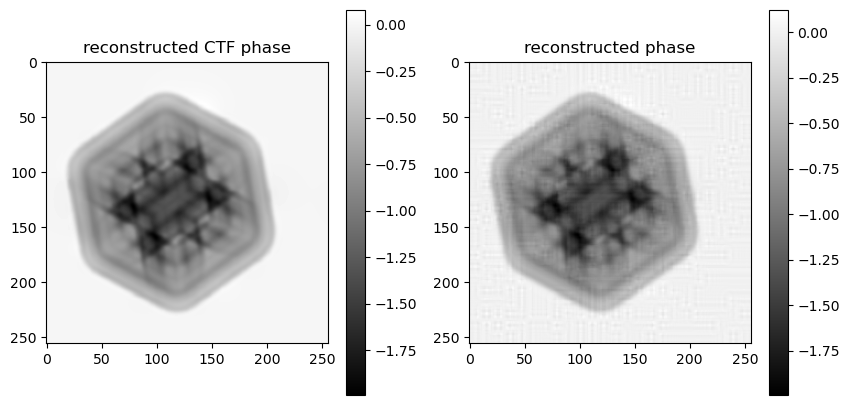

704) gammapsi=1 gammaprb=1.0, err=5.60416e-01


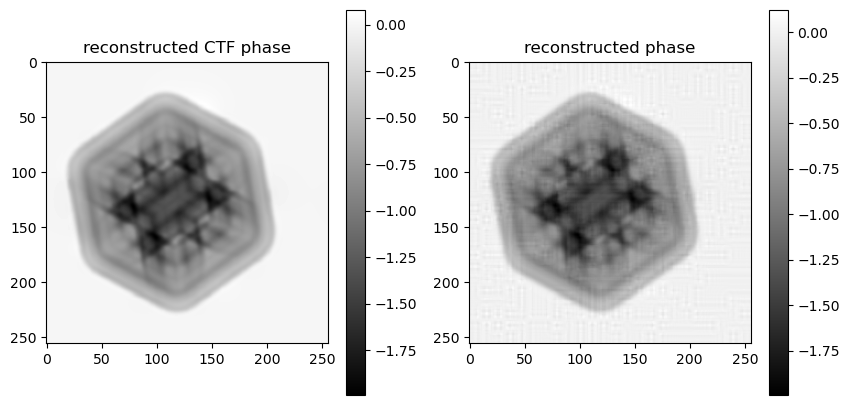

736) gammapsi=1 gammaprb=0.0001220703125, err=5.04745e-01


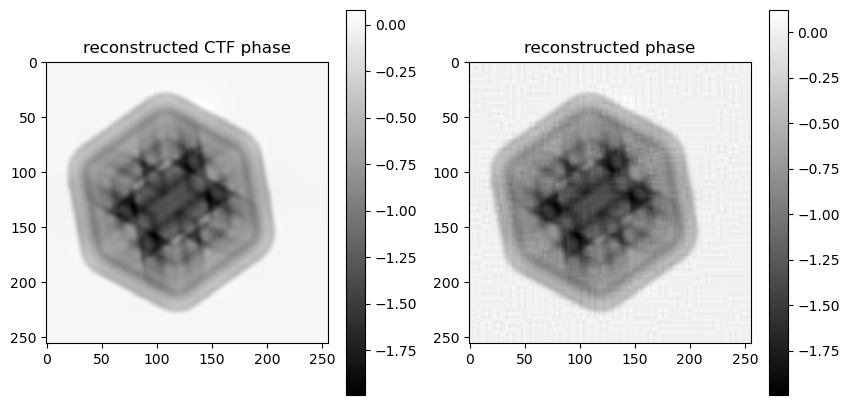

768) gammapsi=0.03125 gammaprb=2, err=4.43701e-01


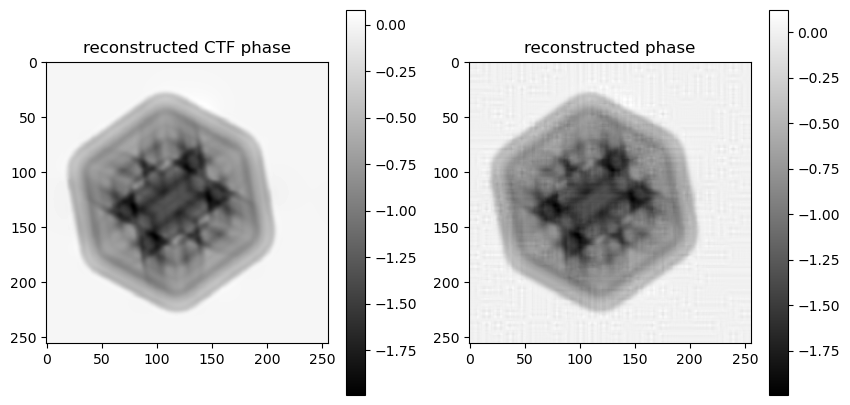

800) gammapsi=1 gammaprb=1.0, err=3.84614e-01


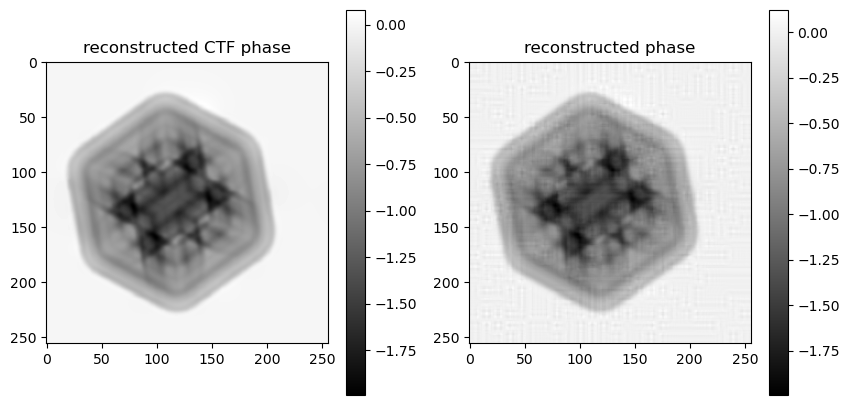

832) gammapsi=0.5 gammaprb=0.125, err=3.39881e-01


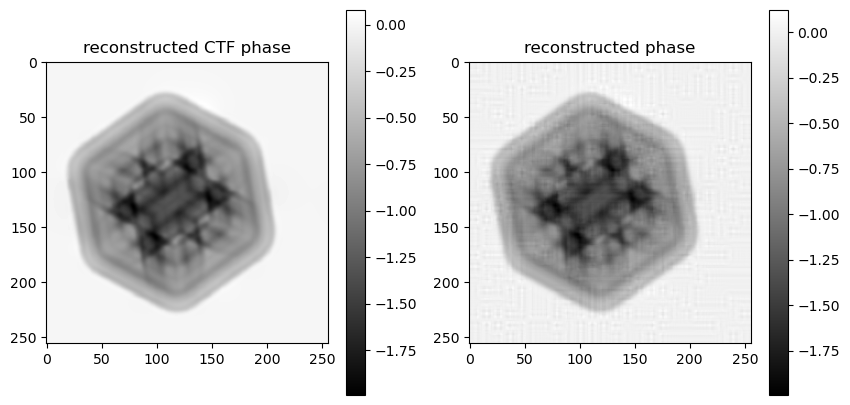

864) gammapsi=1 gammaprb=0.0001220703125, err=2.97610e-01


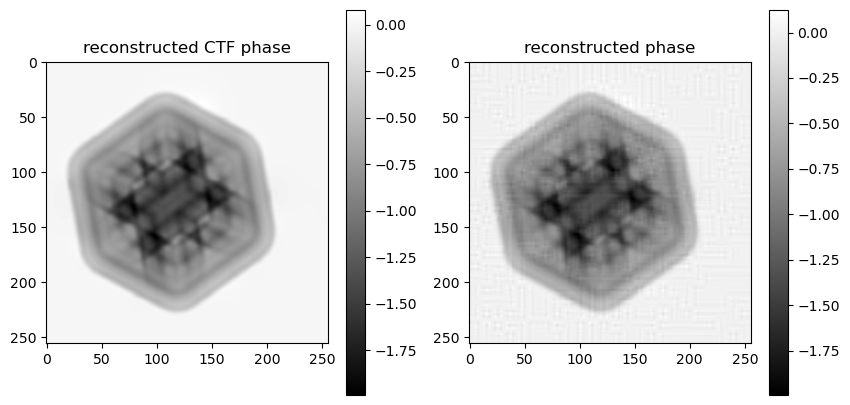

896) gammapsi=0.25 gammaprb=1.0, err=2.74584e-01


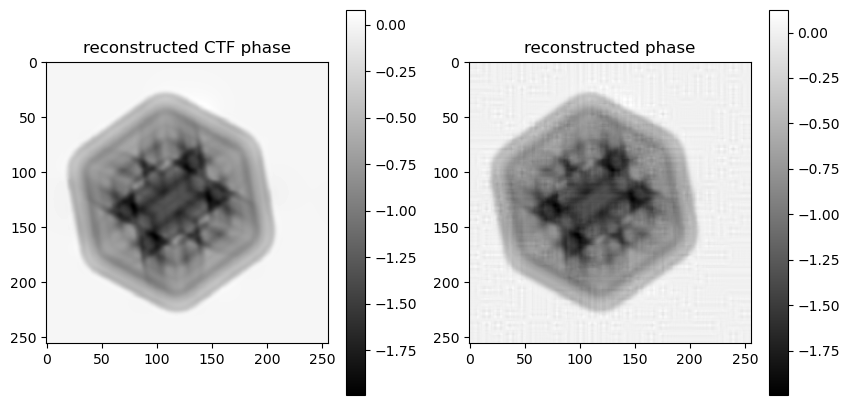

928) gammapsi=1 gammaprb=0.00390625, err=2.55184e-01


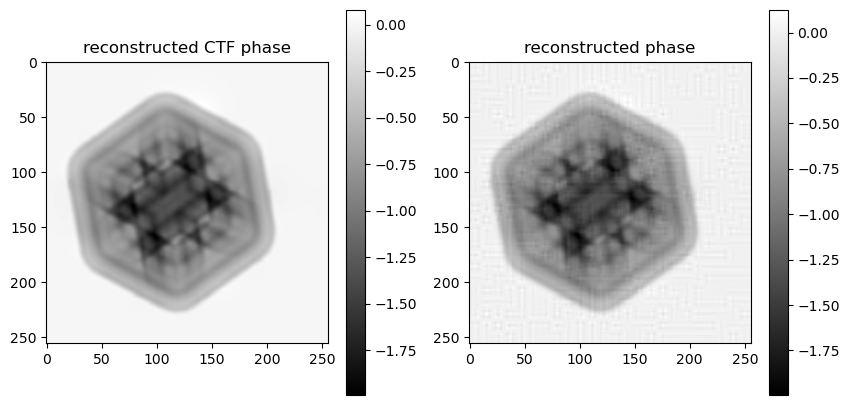

960) gammapsi=1 gammaprb=0.0001220703125, err=2.35299e-01


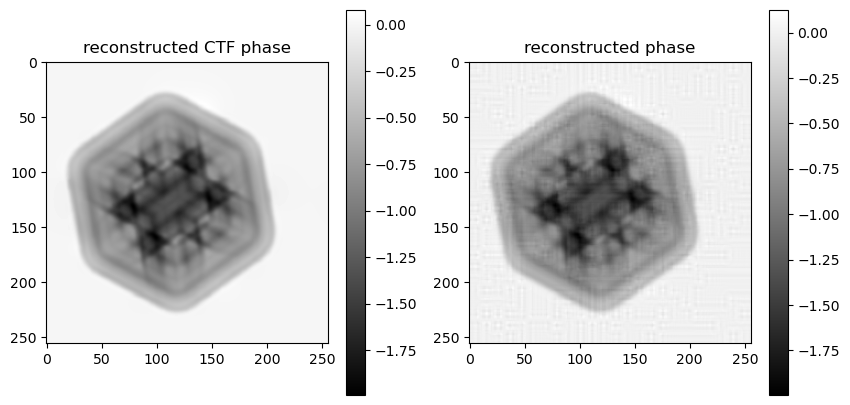

992) gammapsi=1 gammaprb=0.5, err=2.10394e-01


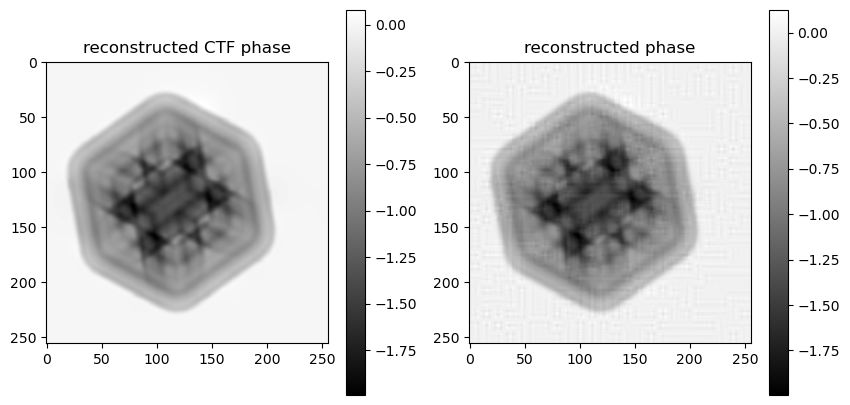

1024) gammapsi=1 gammaprb=1.0, err=1.91872e-01


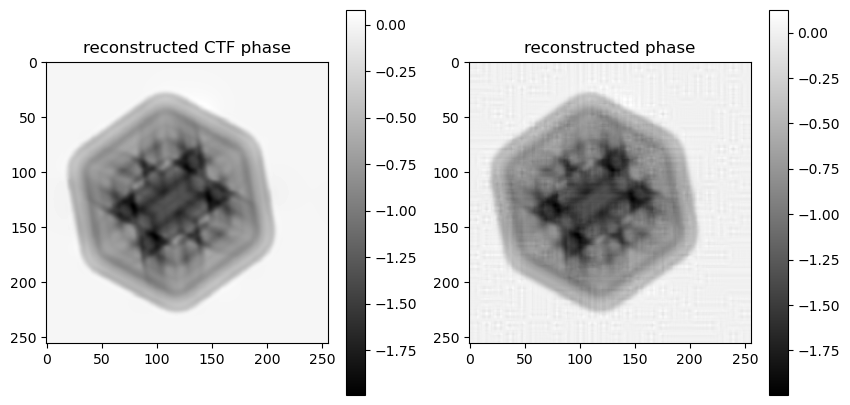

1056) gammapsi=0.5 gammaprb=0.000244140625, err=1.59552e-01


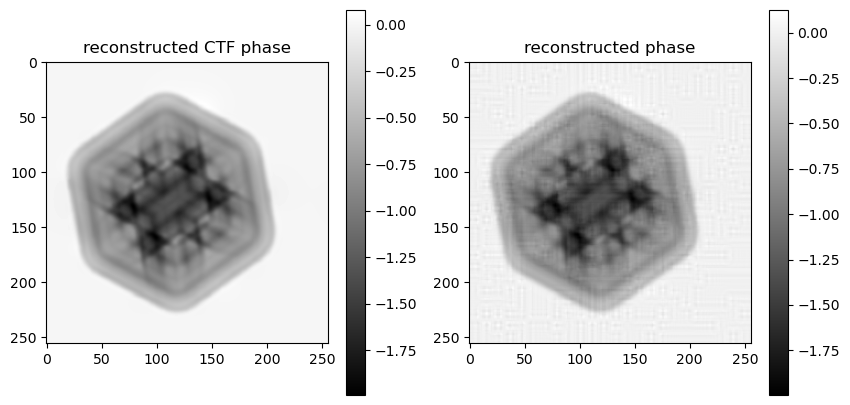

1088) gammapsi=0.5 gammaprb=0.5, err=1.41136e-01


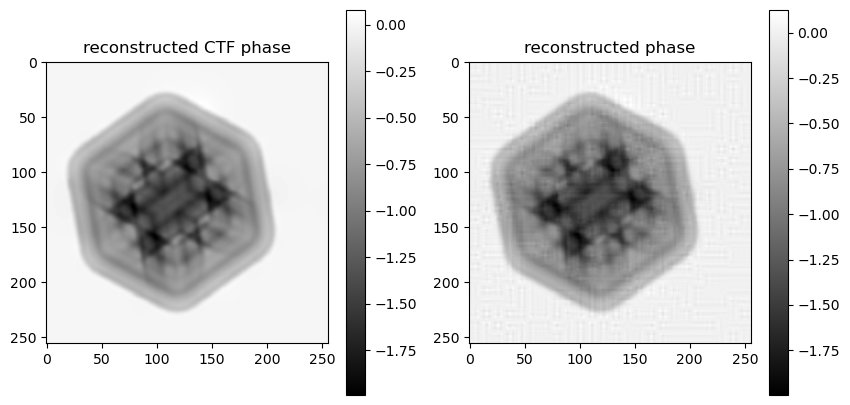

1120) gammapsi=0.5 gammaprb=2, err=1.19289e-01


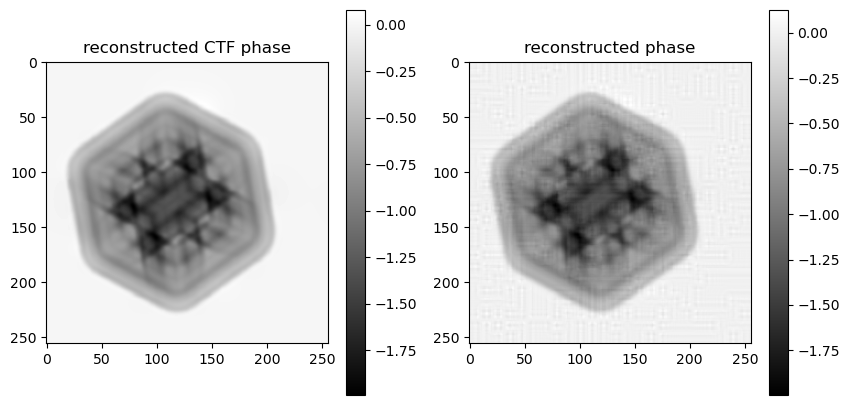

1152) gammapsi=1 gammaprb=0.25, err=9.35883e-02


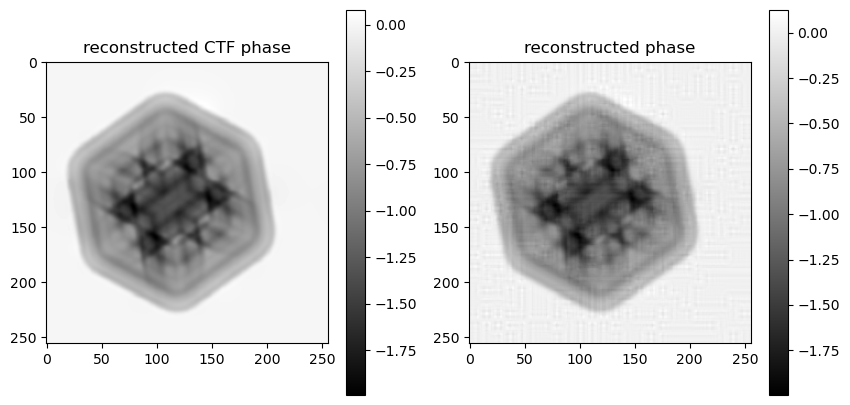

1184) gammapsi=1 gammaprb=3.0517578125e-05, err=8.49053e-02


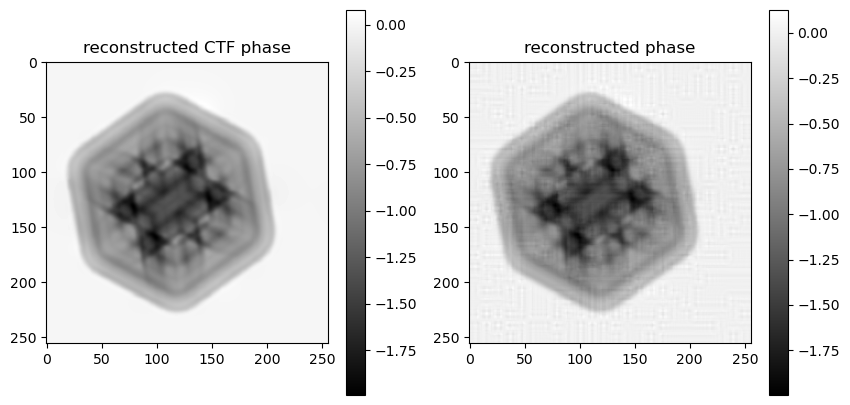

1216) gammapsi=1 gammaprb=0.0001220703125, err=6.77570e-02


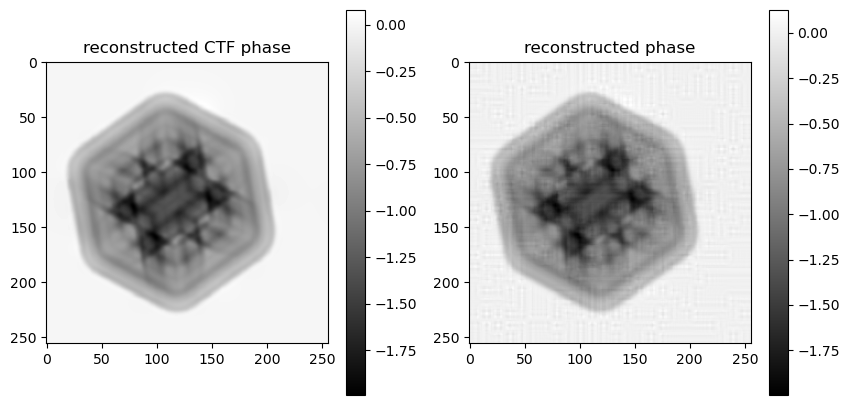

1248) gammapsi=1 gammaprb=1.0, err=5.79783e-02


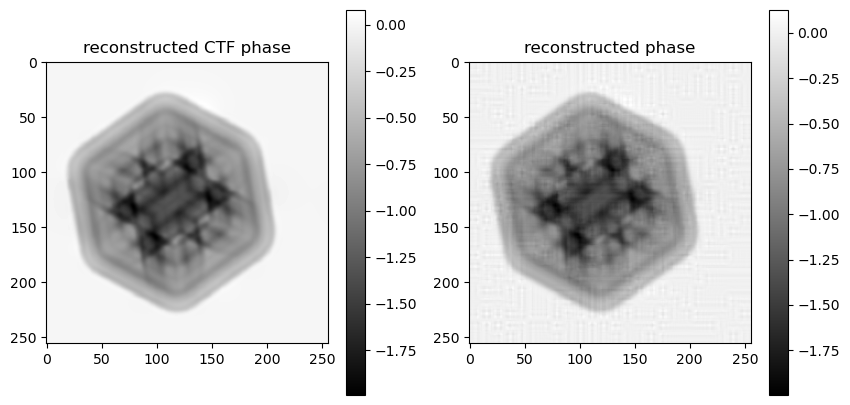

1280) gammapsi=1 gammaprb=1.0, err=5.51362e-02


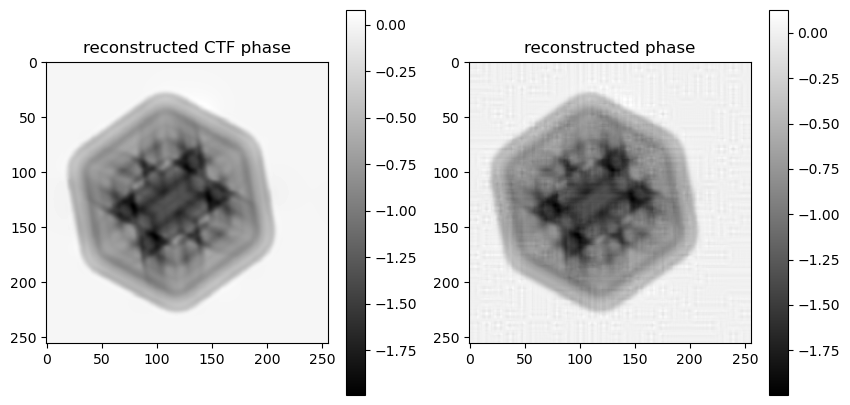

1312) gammapsi=1 gammaprb=1.0, err=4.30719e-02


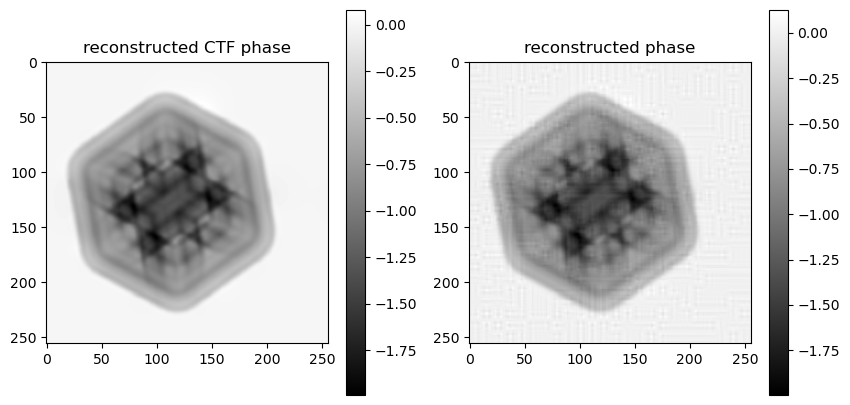

1344) gammapsi=1 gammaprb=1.52587890625e-05, err=3.59646e-02


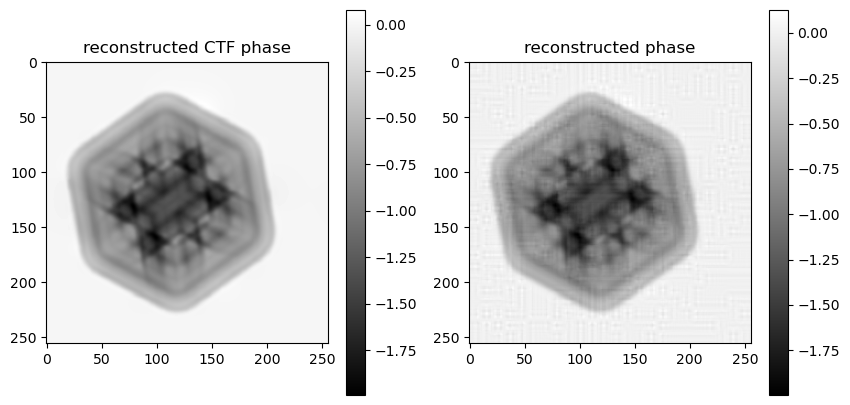

1376) gammapsi=0.5 gammaprb=0.00048828125, err=3.10913e-02


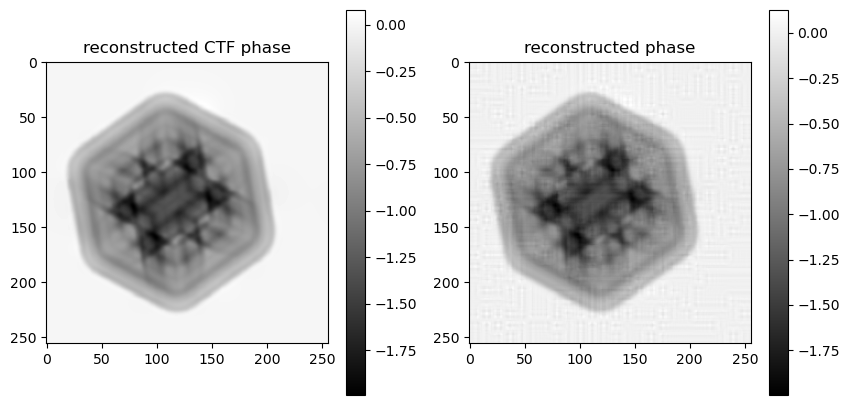

1408) gammapsi=1 gammaprb=3.0517578125e-05, err=2.37021e-02


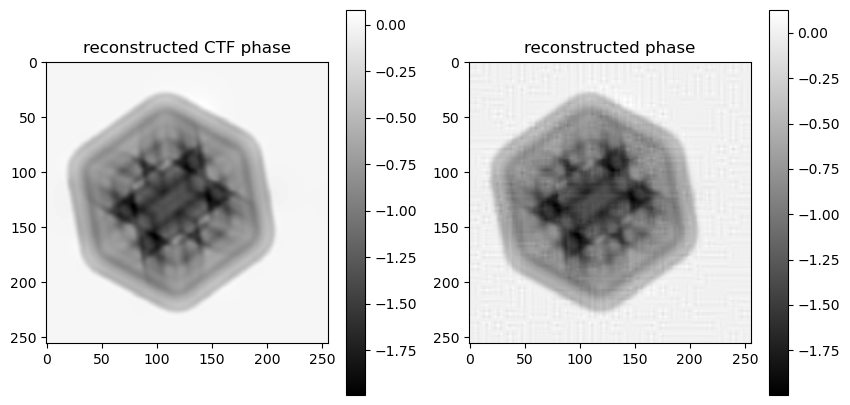

1440) gammapsi=1 gammaprb=0.5, err=1.89059e-02


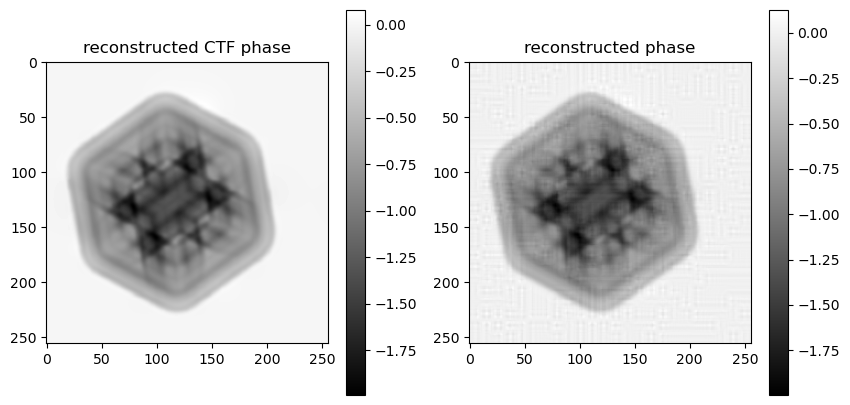

1472) gammapsi=1 gammaprb=6.103515625e-05, err=1.43837e-02


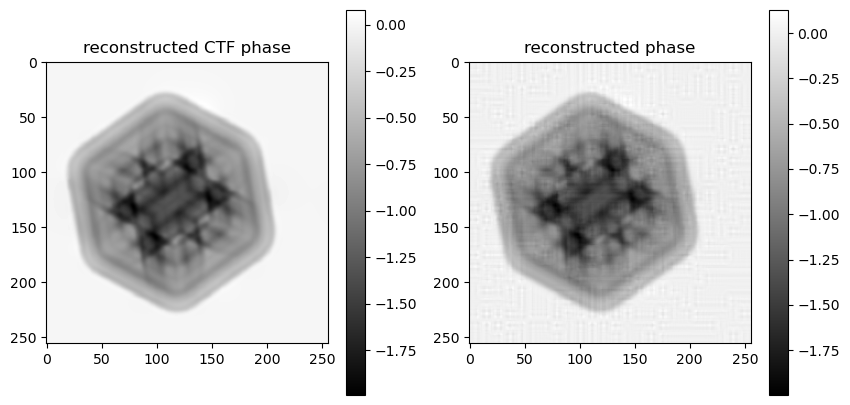

1504) gammapsi=1 gammaprb=1.0, err=1.03157e-02


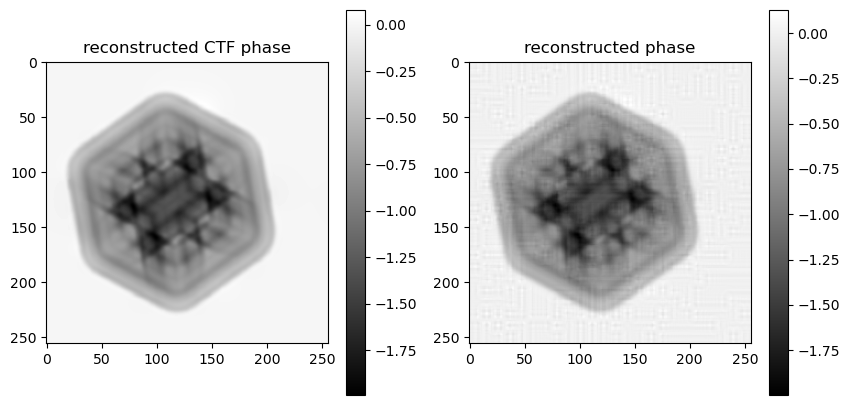

1536) gammapsi=1 gammaprb=1.0, err=8.09688e-03


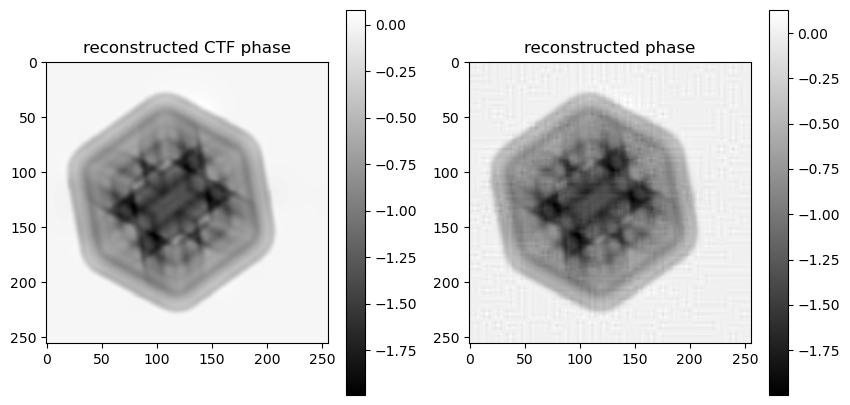

1568) gammapsi=1 gammaprb=0.00048828125, err=7.03309e-03


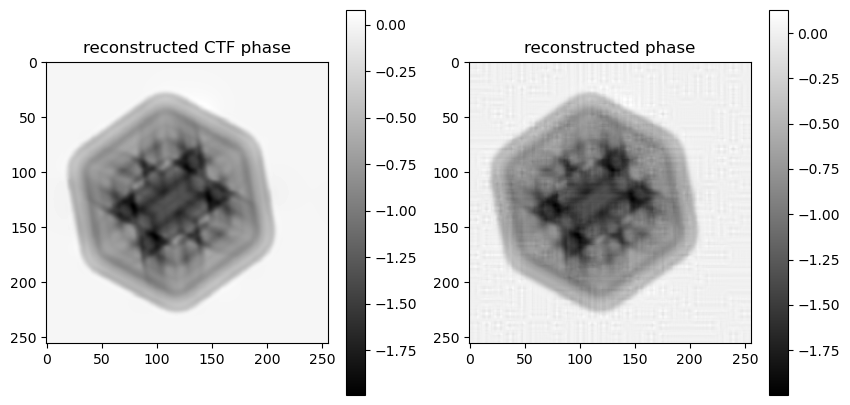

1600) gammapsi=1 gammaprb=1.52587890625e-05, err=6.25501e-03


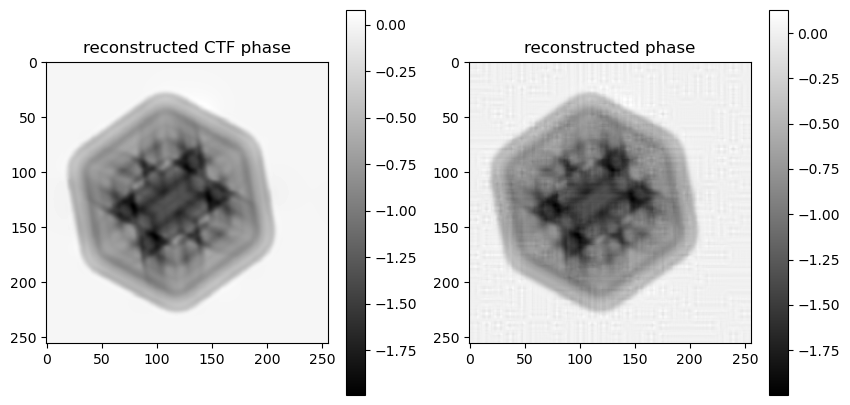

1632) gammapsi=1 gammaprb=0.000244140625, err=5.20575e-03


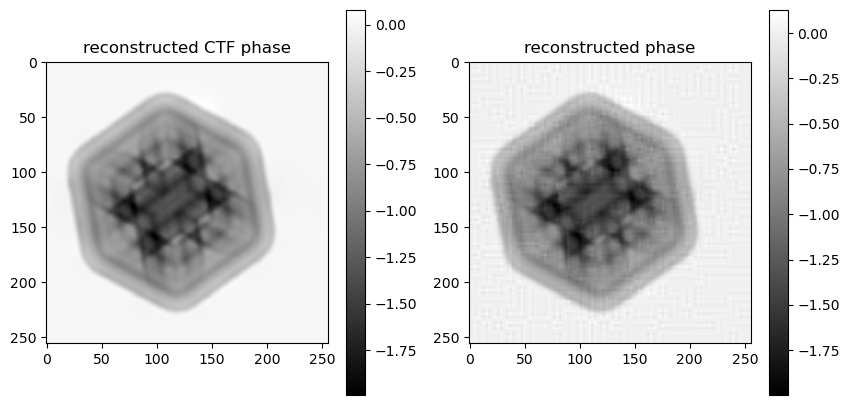

1664) gammapsi=1 gammaprb=1.0, err=5.26606e-03


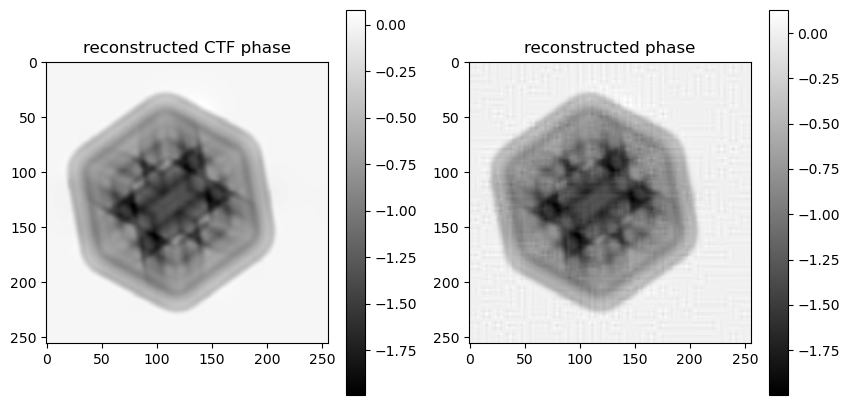

1696) gammapsi=1 gammaprb=0.0001220703125, err=4.05716e-03


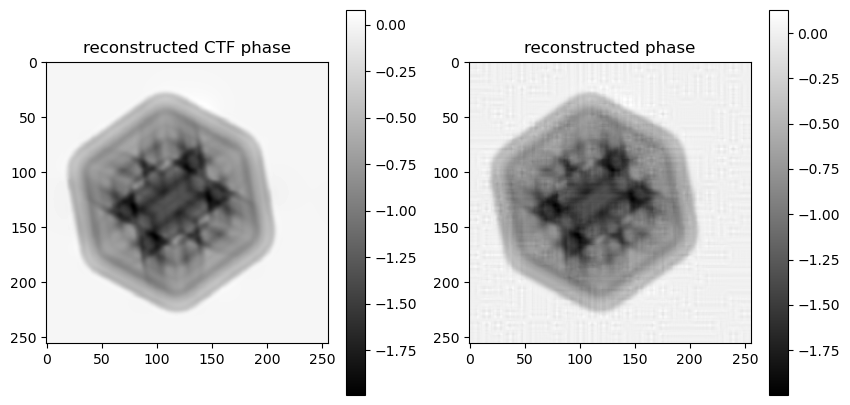

1728) gammapsi=1 gammaprb=0.125, err=3.72580e-03


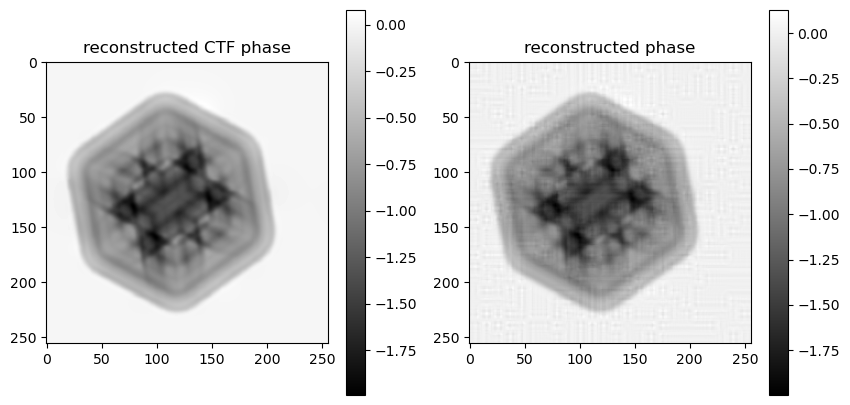

1760) gammapsi=1 gammaprb=2, err=4.10452e-03


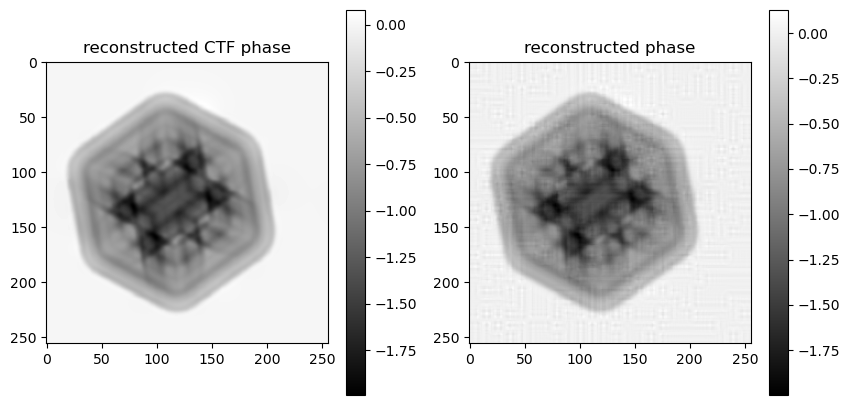

1792) gammapsi=1 gammaprb=0.0001220703125, err=3.66018e-03


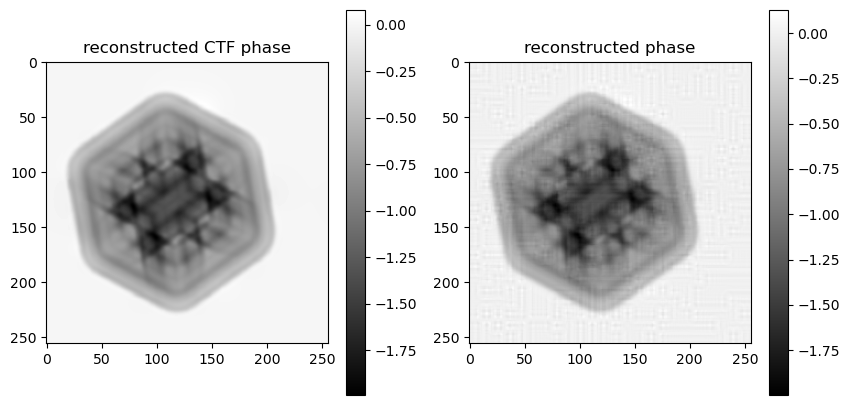

1824) gammapsi=0.25 gammaprb=0.000244140625, err=3.83877e-03


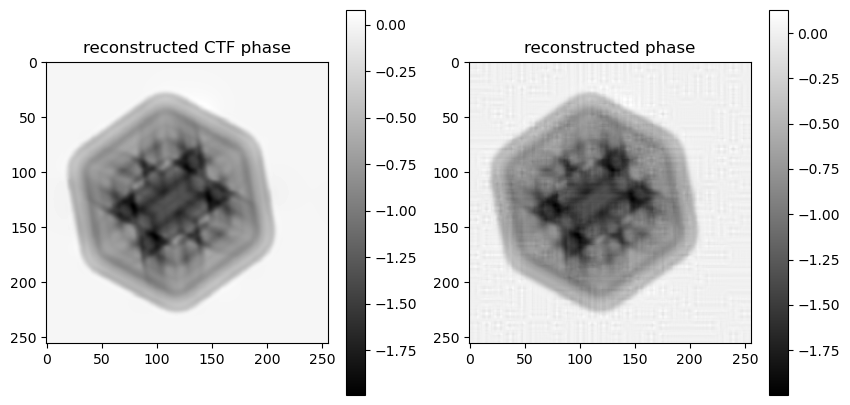

1856) gammapsi=1 gammaprb=0.5, err=2.37358e-03


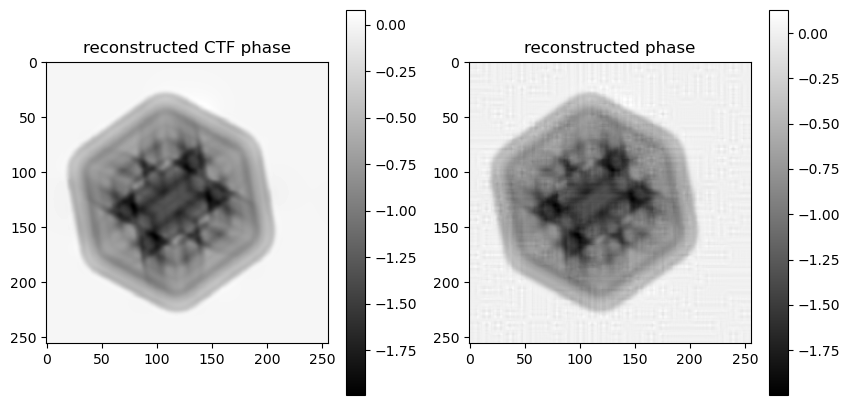

1888) gammapsi=1 gammaprb=0.5, err=2.43819e-03


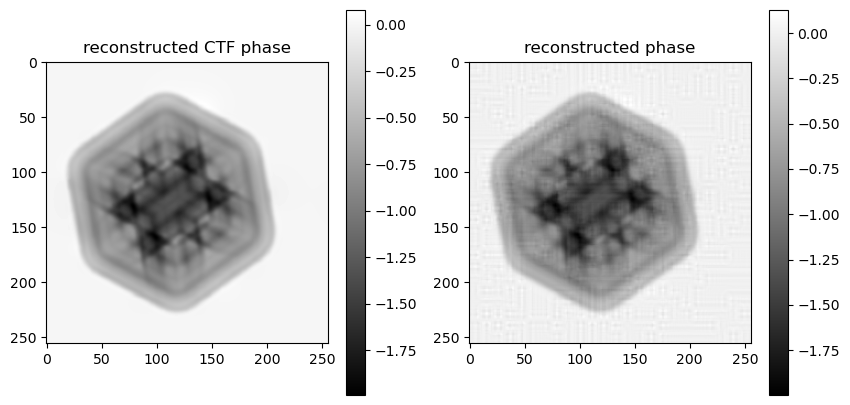

1920) gammapsi=1 gammaprb=0.5, err=2.05470e-03


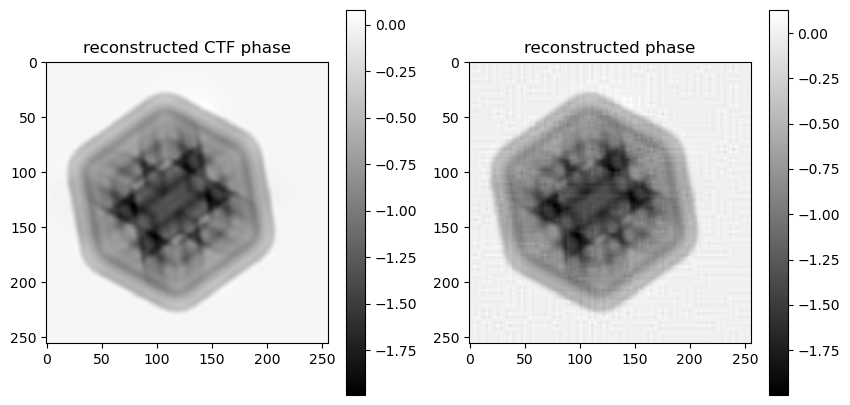

1952) gammapsi=1 gammaprb=0.25, err=1.25273e-03


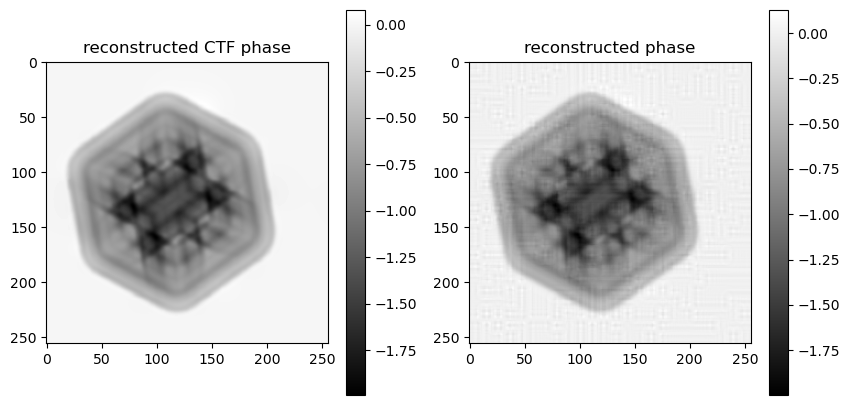

1984) gammapsi=1 gammaprb=0.00048828125, err=1.64317e-03


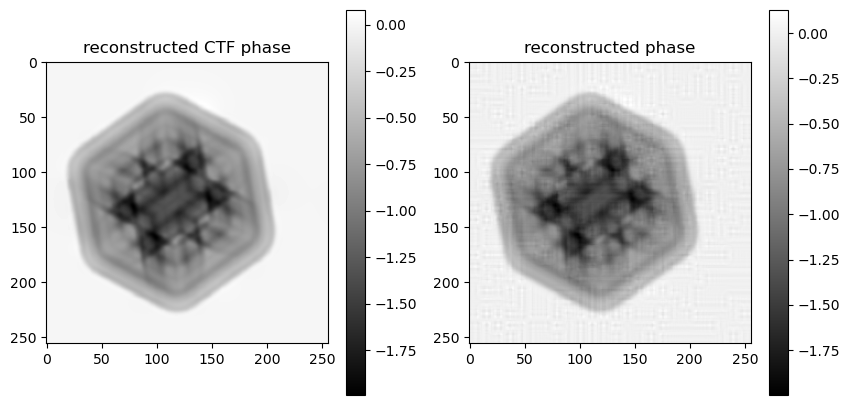

2016) gammapsi=1 gammaprb=0.125, err=6.73277e-04


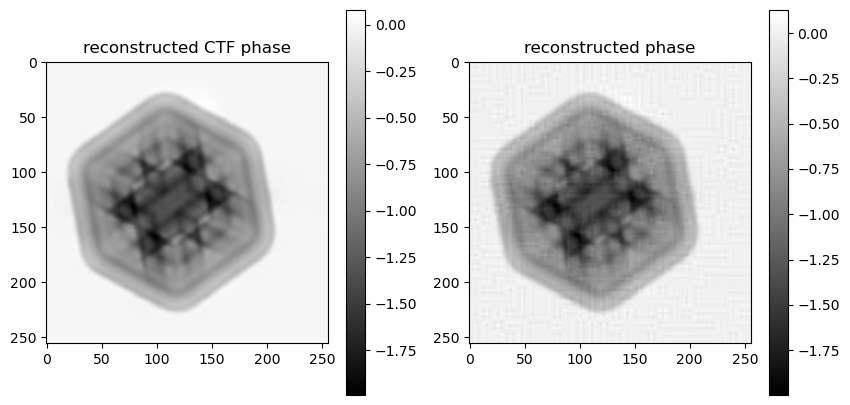

2048) gammapsi=1 gammaprb=0.00048828125, err=6.84267e-04


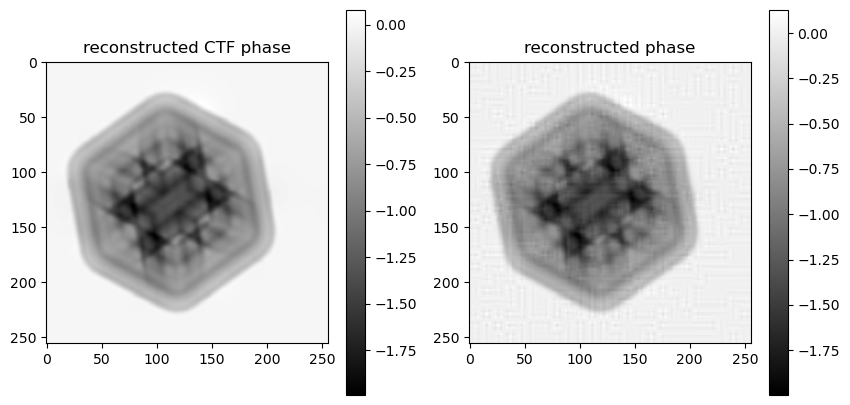

In [22]:
import scipy as sp
def downsample(data, binning):
    res = data.copy()
    for k in range(binning):
        res = 0.5*(res[..., ::2,:]+res[..., 1::2,:])
        res = 0.5*(res[..., ::2]+res[..., 1::2])        
    return res

lbinninga = [0]
iters = [2049]
rec = downsample(rec0,lbinninga[0])
prb = downsample(prb0,lbinninga[0])       
for k,lbinning in enumerate(lbinninga):
    n = n0//2**lbinning
    ne = ne0//2**lbinning
    voxelsize = voxelsize0*2**lbinning
    shifts_rec = shifts_rec0/2**lbinning
    print(f'{n=},{ne=},{voxelsize=}')   
    
    data_ref = np.sqrt(ref0[:,np.newaxis])
    data = np.sqrt(data0)
    
    data = downsample(data,lbinning)
    data_ref = downsample(data_ref0,lbinning)
    
    
    
    pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 
    pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe)     
    rec,prb,conv = cg_holo_batch(pslv, pslv0, data, data_ref, rec, prb, iters[k], shifts_rec, True,True,32,32, 1,2)
    
    rec = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(rec)))
    rec = np.pad(rec,((0,0),(rec.shape[1]//2,rec.shape[1]//2),(rec.shape[1]//2,rec.shape[1]//2)))
    rec = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(rec)))*4
    rec = rec.astype('complex64')
    
    prb = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(prb)))
    prb = np.pad(prb,((0,0),(prb.shape[1]//2,prb.shape[1]//2),(prb.shape[1]//2,prb.shape[1]//2)))
    prb = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(prb)))*4
    prb = prb.astype('complex64')
    
    